## Code to produce figures in Randolph-Flagg et al., *GRL*, 2025.

In [ ]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import scipy
from scipy.integrate import cumulative_trapezoid

## Figure 2

|                        | **gravity**       | **total radius** | **Rocky radius** | **µmeteorite rate** | **PEC** |
| ---------------------- | ----------------- | ---------------- | ---------------- | ------------------- | ------- |
|                        | (m/s<sup>2</sup>) | (km)             | (km)             |                     |         |
| **_Jupiter_**          |                   |                  |                  |                     |         |
| Europa                 | 1.31              | 1,565            | 1,374            | 1e-12               | 6.6e-5  |
| Ganymede               | 1.43              | 2,634            | 2,380            | 6e-14               | 1.2e-4  |
| Callisto               | 1.24              | 2,410            | 2,140            | 3e-14               | 6.1e-5  |
| **_Saturn_**           |                   |                  |                  |                     |         |
| Enceladus              | .085              | 252              | 190              | 4e-14               | 2.2e-6  |
| Titan                  | 1.35              | 1,287            | 2116             | 2e-14               | 5.4e-5  |
| Dione                  | .224              | 562              | 350              | 3e-14               | 7.1e-6  |
| **_Uranus & Neptune_** |                   |                  |                  |                     |         |
| Miranda                | .081              | 230              | 230              | 2e-14               | 5.2e-6  |
| Ariel                  | .29               | 580              | 350              | 2e-14               | 2.1e-5  |
| Umbriel                | .22               | 585              | 350              | 1e-14               | 1.6e-5  |
| Triton                 | .78               | 1,355            | 1,135            | 3e-14               | 7.5e-5  |

**Table S1.** Table of parameters used to calculate cratering rates and sediment thickness in text. Values from Zahnle et al., 2003; Poppe et al., 2021; Hemingway and Mittal, 2019; Weiss et al., 2021.

### Cratering Rates

Cratering rates for ocean worlds are extrapolated from moons and planets which better preserve the distribution of impactors ([Zahnle, 2003](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.520.2964&rep=rep1&type=pdf)). First, crater size $D$ are approximately related to impactor size $d$ in km by

$$D_{s} = 11.9(v^{2}/0.01\vec{g})^{0.217}(\rho_i/\rho_t)^{0.333}d^{0.783}$$

$$
D =
  \begin{cases}
	D_s & \text{($D_s$ < $D_c$)} \\
	D_s(D_s/D_c)^{\zeta} & \text{($D_s$ > $D_c$)} \\
  \end{cases}
$$
(Zahnle, 2003 eq'n 5)

where $D_s$ is the simple crater, $D_c$ is the complex crater, $v$ is the impactor velocity, $\rho_i$ is the impactor density, and $\zeta$ = 0.13 from McKinnon et al., 1991. For now, we assume an impactor denisty of 0.6 g/cm$^3$ from Asphaug and Benz, 1996 and $D_c$ = 2.5 km for Europa and Titan and $D_c$ = 15 km for Enceladus, Mimas, and Dione. Mean impactor velocities are also given my Table in Zahnle (2003).

We use scenario A from Zahnle et al. (2003) where the impactor frequency $\dot{N}$ is a function of meteorite size $d$ (inverted from crater size $D$) and given by a series of discontinuous functions (Zahnle, 2003 eq'n 14)

$$
\dot{N}(>d) =
  \begin{cases}
	\dot{N_j} \frac{d}{1.5}^{-1} & \text{(d < 1.5 km)} \\
	\dot{N_j} \frac{d}{1.5}^{-1.7} & \text{(1.5 < d < 5 km)} \\ 0.129\dot{N_j}  \frac{d}{5}^{-2.5} & \text{(5 < d < 30 km)} \\
	0.00146\dot{N_j}  \frac{d}{30}^{-3.2} & \text{(d < 30 km)} \\
  \end{cases}
$$
where $\dot{N_j}$ is the impactor rate normalized at Jupiter. To convert to cratering rate, $\dot{C} = P_{EC}\dot{N}$ where $P_{EC}$ is the ecliptic comet impact probability relative to Jupiter (i.e., Jupiter's $P_{EC} == 1$). To confirm that we are accurately modeling this intermediate figure is directly comparable with Fig. 3 of Zahnle.

In [ ]:
PEC_Europa = 6.6e-5; PEC_Ganymede = 1.2e-4; PEC_Callisto = 6.1e-5#Jupiter
PEC_Enceladus = 2.2e-6; PEC_Titan = 5.4e-5; PEC_Dione = 7.1e-6 #Saturn
PEC_Miranda = 5.2e-6; PEC_Ariel = 2.1e-5; PEC_Umbriel = 1.6e-5#Uranus
PEC_Triton = 7.5e-5 #Neptune

In [ ]:
g_Europa = 1.3; g_Ganymede = 1.43; g_Callisto = 1.25#Jupiter
g_Enceladus = .085; g_Titan = 1.35; g_Dione = .224 #Saturn
g_Miranda = .081; g_Ariel = .29; g_Umbriel = .22#Uranus
g_Triton = .78 #Neptune

In [ ]:
d = np.geomspace(1e-6, 10000000, 100000) #m # 1 micron to 10,000 km
time = np.linspace(0,4.5,100) #ga

def Cdot_A (P_EC,impactor_size):
    """Impactor size in meters"""
    impactor_size_km = impactor_size * 1e-3
    N_J = 0.005 #impact/year
    C =np.array([])
    for d in impactor_size_km:
        if d <= 1.5:
            Ndot = N_J * (d/1.5)**-1
        elif d <= 5:
            Ndot = N_J * (d/1.5)**-1.7
        elif d <= 30:
            Ndot = 0.129 * N_J * (d/5)**-2.5
        else:
            Ndot = 0.00146 * N_J * (d/30)**-3.2
        C = np.append(C,P_EC * Ndot)
    return  C

def Cdot_B (P_EC,impactor_size):
    """Impactor size in meters. Calibrated to Triton"""
    impactor_size_km = impactor_size * 1e-3
    N_J = 0.005 #impact/year
    C =np.array([])
    for d in impactor_size_km:
        if d <= 1.5:
            Ndot = 2.62 * N_J * (d/1.5)**-1.7
        elif d <= 30:
            Ndot = .129*N_J * (d/5)**-2.5
        else:
            Ndot = .00146*N_J * (d/30)**-3.2
        C = np.append(C,P_EC * Ndot)
    return  C

def Cdot_C (P_EC,impactor_size):
    """Impactor size in meters. Calibrated to Kuiper Belt objects"""
    impactor_size_km = impactor_size * 1e-3
    N_J = 0.005 #impact/year
    C =np.array([])
    for d in impactor_size_km:
        if d <= 6.3:
            Ndot = 0.216 * N_J * (d/6.3)**-2.5
        else:
            Ndot = .00146*N_J * (d/30)**-3.2
        C = np.append(C,P_EC * Ndot)
    return  C

def impactor_to_crater(impactor_size, gravity, velocity, density, Dc):
    """Calculate crater size for velocity in km/s, gravity in m/s2. Suggested velocity and density in Table 1 from Zahnle. Dc = 2.5 km for Europa Ganymede Callisto and Titan, Dc = 15 km for others."""
    g = gravity*1e2; crater_size = np.array([]); v = velocity; Dc_i = Dc
    Ds = 11.9 * (v**2/ g)**.217 * (0.6/density)**.333 * impactor_size**.783;
    for i in np.arange(0,len(impactor_size)):
        if Ds[i] < Dc:
            crater_size = np.append(crater_size, Ds[i])
        else:
            crater_size = np.append(crater_size, Ds[i]*(Ds[i]/Dc)**(.13))
    return crater_size

In [ ]:
### CASE A
### Jupiter
c_Europa_A = Cdot_A(PEC_Europa, d); c_Ganymede_A = Cdot_A(PEC_Ganymede, d); c_Callisto_A = Cdot_A(PEC_Callisto,d)
### Saturn
c_Enceladus_A = Cdot_A(PEC_Enceladus, d); c_Titan_A = Cdot_A(PEC_Titan, d); c_Dione_A = Cdot_A(PEC_Dione, d)
#Uranus
c_Miranda_A = Cdot_A(PEC_Miranda, d); c_Ariel_A = Cdot_A(PEC_Ariel, d); c_Umbriel_A = Cdot_A(PEC_Umbriel,d)
#Neptune
c_Triton_A = Cdot_A(PEC_Triton,d)

In [ ]:
### CASE B
### Jupiter
c_Europa_B = Cdot_B(PEC_Europa, d); c_Ganymede_B = Cdot_B(PEC_Ganymede, d); c_Callisto_B = Cdot_B(PEC_Callisto,d)
### Saturn
c_Enceladus_B = Cdot_B(PEC_Enceladus, d); c_Titan_B = Cdot_B(PEC_Titan, d); c_Dione_B = Cdot_B(PEC_Dione, d)
#Uranus
c_Miranda_B = Cdot_B(PEC_Miranda, d); c_Ariel_B = Cdot_B(PEC_Ariel, d); c_Umbriel_B = Cdot_B(PEC_Umbriel,d)
#Neptune
c_Triton_B = Cdot_B(PEC_Triton,d)

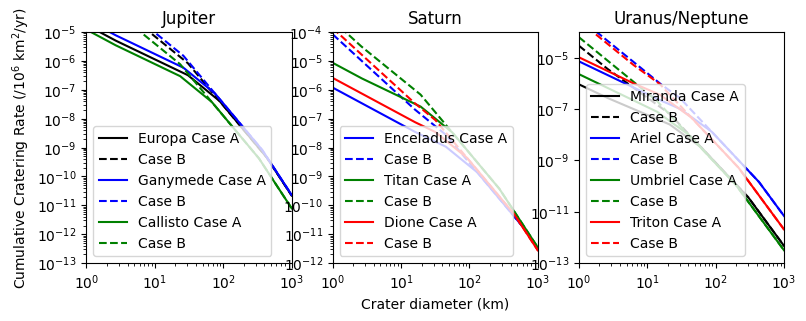

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))

crater_d = impactor_to_crater(d*1e-3, g_Europa, 26, .6/.9, 2.5)
ax1.plot(crater_d,c_Europa_A, 'k'); ax1.plot(crater_d,c_Europa_B, 'k--');

crater_d = impactor_to_crater(d*1e-3, g_Ganymede, 20, .6/.9, 2.5)
ax1.plot(crater_d,c_Ganymede_A,'b'); ax1.plot(crater_d,c_Ganymede_B, 'b--');

crater_d = impactor_to_crater(d*1e-3, g_Callisto, 15, .6/.9, 2.5)
ax1.plot(crater_d,c_Callisto_A,'g'); ax1.plot(crater_d,c_Callisto_B, 'g--');

crater_d = impactor_to_crater(d*1e-3, g_Enceladus, 24, .6/.9, 15)
ax2.plot(crater_d,c_Enceladus_A,'b'); ax2.plot(crater_d,c_Enceladus_B, 'b--');

crater_d = impactor_to_crater(d*1e-3, g_Titan, 10.5, .6/.9, 2.5)
ax2.plot(crater_d,c_Titan_A,'g'); ax2.plot(crater_d,c_Titan_B, 'g--');

crater_d = impactor_to_crater(d*1e-3, g_Dione, 19, .6/.9, 15)
ax2.plot(crater_d,c_Dione_A,'r'); ax2.plot(crater_d,c_Dione_B, 'r--');

crater_d = impactor_to_crater(d*1e-3, 1.3, 12.5, .6/.9, 2.5)
ax3.plot(crater_d,c_Miranda_A, 'k'); ax3.plot(crater_d,c_Miranda_B, 'k--');

crater_d = impactor_to_crater(d*1e-3, .08, 10.3, .6/.9, 15)
ax3.plot(crater_d,c_Ariel_A,'b'); ax3.plot(crater_d,c_Ariel_B, 'b--');

crater_d = impactor_to_crater(d*1e-3, 1.35, 8.7, .6/.9, 15)
ax3.plot(crater_d,c_Umbriel_A,'g'); ax3.plot(crater_d,c_Umbriel_B, 'g--');

crater_d = impactor_to_crater(d*1e-3, 1.35, 8.2, .6/.9, 6)
ax3.plot(crater_d,c_Triton_A,'r'); ax3.plot(crater_d,c_Triton_B, 'r--');

#plt.vlines([1.5,5,30],1e-13,1e-5)
ax1.set_xlim(1,1e3); ax1.set_ylim(1e-13,1e-5)
ax2.set_xlim(1,1e3); ax2.set_ylim(1e-12,1e-4)
ax3.set_xlim(1,1e3); ax3.set_ylim(1e-13,1e-4)
ax1.set_ylabel ('Cumulative Cratering Rate (/10$^6$ km$^2$/yr)')
ax2.set_xlabel ('Crater diameter (km)')
#plt.grid(b=True, which='major', color='lightgray', linestyle='-')
ax1.set_xscale('log'); ax2.set_xscale('log'); ax3.set_xscale('log')
ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log')

ax1.legend(labels=['Europa Case A','Case B', 'Ganymede Case A', 'Case B', 'Callisto Case A', 'Case B'])
ax2.legend( labels=['Enceladus Case A','Case B', 'Titan Case A', 'Case B', 'Dione Case A', 'Case B'])
ax3.legend(labels=['Miranda Case A','Case B', 'Ariel Case A', 'Case B', 'Umbriel Case A', 'Case B', 'Triton Case A', 'Case B'])

ax1.set_title('Jupiter')  # Use set_title() method
ax2.set_title('Saturn')   # Use set_title() method
ax3.set_title('Uranus/Neptune') # Use set_title() method

plt.show()
#plt.savefig('C_Jupiter.png', dpi=200)
plt.close()

### Sediment large impactors accumulation

The total reservoir of impactors then is given by

$$
N = \int_{0}^{4.6}\int_{0}^{SA}\dot{N}   \space\space dAdt
$$

where the cratering rate $\dot{N}$ is integrated over the moon's surface area $SA$ ~ ($4 \pi r^2$) where $r$ is the radius of the moon. This rate is then integrated over the age of the moon although this is likely a very conservative estimate given that the early solar system had many more impacts.

The mass of this reservoir of impactors is given by

$$
\dot{M} =   \int_{0}^{d} \frac{4}{3} \rho_i \pi d^3  \space\space dd
$$

where $\rho_i$ is the density of the impactor. To calcuate the resultant average sediment thickness $\bar{s}_m$ we assume that this mass reaches the seafloor

$$
\bar{s}_m = \frac{M}{\rho_s} \frac{(1+n)}{SA_{sf}}
$$

where $n$ is the sediment porosity, $\rho_s$ is the sediment density, and $SA_{sf}$ is the seafloor surface area.

One concern with this approach is meteorites larger than those modeled by micrometeorite fluxes (> ~1 mm) or smaller than those implied by cratering rates (< ~100 m) are not observationally constrained. We extrapolate the power-law curves from Zahnle et al. (2003) to micrometeorite sizes which is likely an upperbound on these intermediate sized particles.

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def SA_sphere(radius):
    SA = 4 * np.pi * radius**2
    return SA

def mass_impactor (impactor_diameter, meteorite_density):
    mass_per_impactor_size = 4/3 * np.pi * (impactor_diameter/2)**3 * meteorite_density
    return mass_per_impactor_size #per Ga

def sediment_mass (cratering_rate, radius_moon, impactor_diameter, meteorite_density):
    # impactor_diameter in m ..
    # radius_moon is in m
    SA = SA_sphere(radius_moon*1e-3) #km2
    M_i = mass_impactor (impactor_diameter, meteorite_density) #kg/#
    ## integrated mass ..
    #M = cratering_rate * 1e9 * SA * 1e-6 * M_i #/Ga -- Cumulative mass
    M = -np.diff(cratering_rate)/np.diff(impactor_diameter) * 1e9 * M_i[1:] #/Ga -- Differential mass/meter
    return M

def sediment_thickness (mass, radius_RI, impactor_diameter, sediment_density, porosity, max_percentage_impactor, time):
    radius_max = radius_RI * max_percentage_impactor * 1e-2;
    diam_max = find_nearest(impactor_diameter, radius_max*2)
    a = find_nearest(d, diam_max); # So actually using
    b = np.where(d == a);
    b = int(b[0])
    #print(b)
    #mass = np.diff(cum_mass)/np.diff(impactor_diameter)   #/Ga/m
    total_mass = cumulative_trapezoid (mass[:b], impactor_diameter[:b])[-1]*time
    SA_RI = SA_sphere(radius_RI) #m2
    sediment_thickness = total_mass/SA_RI * (1+porosity)/sediment_density
    return sediment_thickness

In [ ]:
## Total radii of moon
Enceladus_radius = 252; Titan_radius = 2574; Europa_radius = 1565; Ganymede_radius = 2634; Callisto_radius = 2410 #km
Miranda_radius = 230; Ariel_radius = 580; Umbriel_radius = 585; Triton_radius = 1355; Dione_radius = 561 #km

## Radii of rocky interior
Enceladus_RI = 190; Titan_RI = 2116; Europa_RI = 1374; Ganymede_RI = 2380; Callisto_RI = 2140 #km
Miranda_RI = 230; Ariel_RI = 350; Umbriel_RI = 350; Triton_RI = 1135; Dione_RI = 350 #km

In [ ]:
## Mass of impactors
reservoir_Enceladus_A = sediment_mass (c_Enceladus_A, Enceladus_radius*1e3, d, 1000); reservoir_Europa_A = sediment_mass (c_Europa_A, Europa_radius*1e3, d, 1000)
reservoir_Titan_A = sediment_mass (c_Titan_A, Titan_radius*1e3, d, 1000); reservoir_Dione_A = sediment_mass (c_Dione_A, Dione_radius*1e3, d, 1000)
reservoir_Miranda_A = sediment_mass (c_Miranda_A, Miranda_radius*1e3, d, 1000); reservoir_Callisto_A = sediment_mass (c_Callisto_A, Callisto_radius*1e3, d, 1000);
reservoir_Ariel_A = sediment_mass (c_Ariel_A, Ariel_radius*1e3, d, 1000); reservoir_Umbriel_A = sediment_mass (c_Umbriel_A, Umbriel_radius*1e3, d, 1000); reservoir_Triton_A = sediment_mass (c_Triton_A, Triton_radius*1e3, d, 1000)
reservoir_Ganymede_A = sediment_mass (c_Ganymede_A, Ganymede_radius*1e3, d, 1000)

reservoir_Enceladus_B = sediment_mass (c_Enceladus_B, Enceladus_radius*1e3, d, 1000); reservoir_Europa_B = sediment_mass (c_Europa_B, Europa_radius*1e3, d, 1000)
reservoir_Titan_B = sediment_mass (c_Titan_B, Titan_radius*1e3, d, 1000); reservoir_Dione_B = sediment_mass (c_Dione_B, Dione_radius*1e3, d, 1000); reservoir_Ganymede_B = sediment_mass (c_Ganymede_B, Ganymede_radius*1e3, d, 1000)
reservoir_Miranda_B = sediment_mass (c_Miranda_B, Miranda_radius*1e3, d, 1000); reservoir_Callisto_B = sediment_mass (c_Callisto_B, Callisto_radius*1e3, d, 1000);
reservoir_Ariel_B = sediment_mass (c_Ariel_B, Ariel_radius*1e3, d, 1000); reservoir_Umbriel_B = sediment_mass (c_Umbriel_B, Umbriel_radius*1e3, d, 1000); reservoir_Triton_B = sediment_mass (c_Triton_B, Triton_radius*1e3, d, 1000)

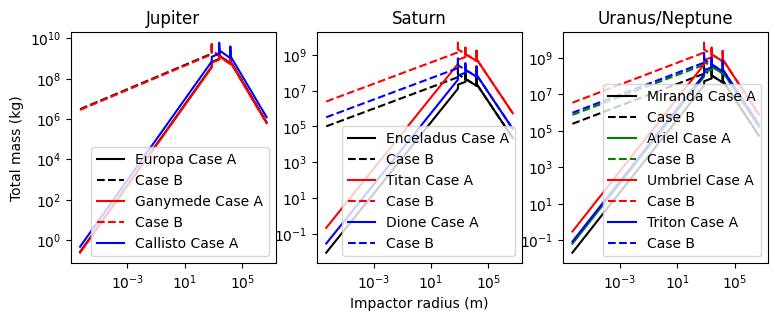

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))

ax1.plot(d[1:]/2, reservoir_Europa_A*1e-3, 'k'); ax1.plot(d[1:]/2, reservoir_Europa_B*1e-3, 'k--'); ax1.plot(d[1:]/2, reservoir_Callisto_A*1e-3,'r');
ax1.plot(d[1:]/2, reservoir_Callisto_B*1e-3, 'r--'); ax1.plot(d[1:]/2, reservoir_Ganymede_A*1e-3,'b');

ax2.plot(d[1:]/2, reservoir_Enceladus_A*1e-3, 'k'); ax2.plot(d[1:]/2, reservoir_Enceladus_B*1e-3, 'k--'); ax2.plot(d[1:]/2, reservoir_Titan_A*1e-3,'r')
ax2.plot(d[1:]/2, reservoir_Titan_B*1e-3, 'r--'); ax2.plot(d[1:]/2, reservoir_Dione_A*1e-3,'b'); ax2.plot(d[1:]/2, reservoir_Dione_B*1e-3, 'b--');

ax3.plot(d[1:]/2, reservoir_Miranda_A*1e-3, 'k'); ax3.plot(d[1:]/2, reservoir_Miranda_B*1e-3, 'k--'); ax3.plot(d[1:]/2, reservoir_Umbriel_A*1e-3,'g');
ax3.plot(d[1:]/2, reservoir_Umbriel_B*1e-3, 'g--'); ax3.plot(d[1:]/2, reservoir_Triton_A*1e-3,'r'); ax3.plot(d[1:]/2, reservoir_Triton_B*1e-3, 'r--'); ax3.plot(d[1:]/2, reservoir_Ariel_A*1e-3,'b');
ax3.plot(d[1:]/2, reservoir_Ariel_B*1e-3, 'b--');

ax1.set_xscale('log'); ax2.set_xscale('log'); ax3.set_xscale('log')
ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log')

ax1.legend(labels=['Europa Case A','Case B', 'Ganymede Case A', 'Case B', 'Callisto Case A', 'Case B'])
ax2.legend( labels=['Enceladus Case A','Case B', 'Titan Case A', 'Case B', 'Dione Case A', 'Case B'])
ax3.legend(labels=['Miranda Case A','Case B', 'Ariel Case A', 'Case B', 'Umbriel Case A', 'Case B', 'Triton Case A', 'Case B'])

ax1.set_title('Jupiter')  # Use set_title() method
ax2.set_title('Saturn')   # Use set_title() method
ax3.set_title('Uranus/Neptune') # Use set_title() method

ax1.set_ylabel('Total mass (kg)')
ax2.set_xlabel('Impactor radius (m)')

plt.show()
#plt.savefig("Impactors.png", dpi=200)

In [ ]:
##Sediment thickness calculations
s_Enceladus_A = sediment_thickness(reservoir_Enceladus_A, Enceladus_RI*1e3, d, 1100, .9, 15, time)
s_Europa_A = sediment_thickness(reservoir_Europa_A, Europa_RI*1e3, d, 1100, .9, 15, time)
s_Titan_A = sediment_thickness(reservoir_Titan_A, Titan_RI*1e3, d, 1100, .9, 15, time)
s_Dione_A = sediment_thickness(reservoir_Dione_A, Dione_RI*1e3, d, 1100, .9, 15, time)
s_Ganymede_A = sediment_thickness(reservoir_Ganymede_A, Ganymede_RI*1e3, d, 1100, .9, 15, time)
s_Callisto_A = sediment_thickness(reservoir_Callisto_A, Callisto_RI*1e3, d, 1100, .9, 15, time)
s_Miranda_A = sediment_thickness(reservoir_Miranda_A, Miranda_RI*1e3, d, 1100, .9, 15, time)
s_Ariel_A = sediment_thickness(reservoir_Ariel_A, Ariel_RI*1e3, d, 1100, .9, 15, time)
s_Umbriel_A = sediment_thickness(reservoir_Umbriel_A, Umbriel_RI*1e3, d, 1100, .9, 15, time)
s_Triton_A = sediment_thickness(reservoir_Triton_A, Triton_RI*1e3, d, 1100, .9, 15, time)

s_Enceladus_B = sediment_thickness(reservoir_Enceladus_B, Enceladus_RI*1e3, d, 1100, .9, 15, time)
s_Europa_B = sediment_thickness(reservoir_Europa_B, Europa_RI*1e3, d, 1100, .9, 15, time)
s_Titan_B = sediment_thickness(reservoir_Titan_B, Titan_RI*1e3, d, 1100, .9, 15, time)
s_Ganymede_B = sediment_thickness(reservoir_Ganymede_B, Ganymede_RI*1e3, d, 1100, .9, 15, time)
s_Dione_B = sediment_thickness(reservoir_Dione_B, Dione_RI*1e3, d, 1100, .9, 15, time)
s_Callisto_B = sediment_thickness(reservoir_Callisto_B, Callisto_RI*1e3, d, 1100, .9, 15, time)
s_Miranda_B = sediment_thickness(reservoir_Miranda_B, Miranda_RI*1e3, d, 1100, .9, 15, time)
s_Ariel_B = sediment_thickness(reservoir_Ariel_B, Ariel_RI*1e3, d, 1100, .9, 15, time)
s_Umbriel_B = sediment_thickness(reservoir_Umbriel_B, Umbriel_RI*1e3, d, 1100, .9, 15, time)
s_Triton_B = sediment_thickness(reservoir_Triton_B, Triton_RI*1e3, d, 1100, .9, 15, time)

<ipython-input-8-1a503c2fdb2e>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = int(b[0])


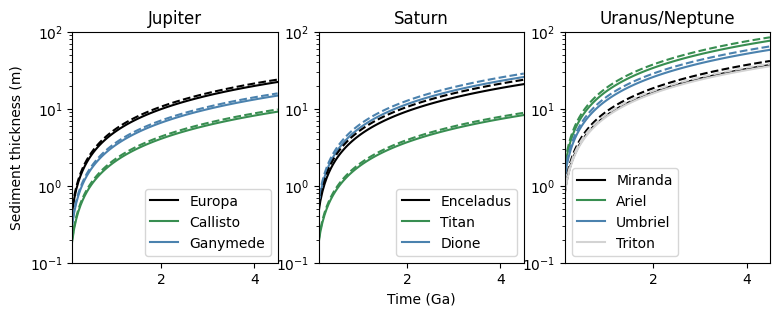

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))

# Plotting for Jupiter
line1, = ax1.plot(time, s_Europa_A, 'k', label='Europa')
line2, = ax1.plot(time, s_Callisto_A, '#388e51', label='Callisto')
line3, = ax1.plot(time, s_Ganymede_A, '#4b82ae', label='Ganymede')

ax1.plot(time, s_Europa_B, 'k--')
ax1.plot(time, s_Callisto_B, '#388e51', linestyle='--')
ax1.plot(time, s_Ganymede_B, '#4b82ae', linestyle='--')

# Plotting for Saturn
line4, = ax2.plot(time, s_Enceladus_A, 'k', label='Enceladus')
line5, = ax2.plot(time, s_Titan_A, '#388e51', label='Titan')
line6, = ax2.plot(time, s_Dione_A, '#4b82ae', label='Dione')

ax2.plot(time, s_Enceladus_B, 'k--')
ax2.plot(time, s_Titan_B, '#388e51', linestyle='--')
ax2.plot(time, s_Dione_B, '#4b82ae', linestyle='--')

# Plotting for Uranus/Neptune
line7, = ax3.plot(time, s_Miranda_A, 'k', label='Miranda')
line8, = ax3.plot(time, s_Ariel_A, '#388e51', label='Ariel')
line9, = ax3.plot(time, s_Umbriel_A, '#4b82ae', label='Umbriel')
line10, = ax3.plot(time, s_Triton_A, 'lightgray', label='Triton')

ax3.plot(time, s_Miranda_B, 'k--')
ax3.plot(time, s_Ariel_B, '#388e51', linestyle='--')
ax3.plot(time, s_Umbriel_B, '#4b82ae', linestyle='--')
ax3.plot(time, s_Triton_B, 'lightgrey', linestyle='--')

# Axis settings
ax1.set_xlim(1,4); ax1.set_ylim(1e-1,1e4)
ax2.set_xlim(1,4); ax2.set_ylim(1e-1,1e4)
ax3.set_xlim(1,4); ax3.set_ylim(1e-1,1e4)

ax1.set_ylabel ('Sediment thickness (m)')
ax2.set_xlabel ('Time (Ga)')

ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log')

# Updating legend to include only 'Case A'
ax1.legend(handles=[line1, line2, line3])
ax2.legend(handles=[line4, line5, line6])
ax3.legend(handles=[line7, line8, line9, line10])

ax1.set_title('Jupiter')
ax2.set_title('Saturn')
ax3.set_title('Uranus/Neptune')

ax1.set_ylim(1e-1, 1e2); ax2.set_ylim(1e-1, 1e2); ax3.set_ylim(1e-1, 1e2)
ax1.set_xlim(0.1,4.5); ax2.set_xlim(0.1,4.5); ax3.set_xlim(0.1,4.5)

plt.show()
plt.close()


**Figure 2.** Globally averaged meteorite-sourced sediment accumulation for different ocean worlds assuming perfect transport through the ice shell. Solid lines show Case A and dashed lines show Case B impactor models from Zahnle et al. (2003). Sediment thickness for (a) Jupiter, (b) Saturn, and (c) Uranus and Neptune moon systems.

Calculate the Earth-equivalent sediment thickness by scaling to gravity.

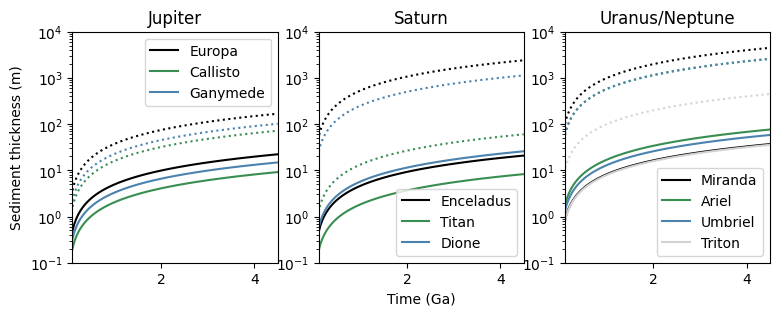

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))

# Plotting for Jupiter
line1, = ax1.plot(time, s_Europa_A, 'k', label='Europa')
line2, = ax1.plot(time, s_Callisto_A, '#388e51', label='Callisto')
line3, = ax1.plot(time, s_Ganymede_A, '#4b82ae', label='Ganymede')

ax1.plot(time, s_Europa_A*(9.81/g_Europa), 'k',  linestyle='dotted')
ax1.plot(time, s_Callisto_A*(9.81/g_Callisto), '#388e51',  linestyle='dotted')
ax1.plot(time, s_Ganymede_A*(9.81/g_Ganymede), '#4b82ae',  linestyle='dotted')

# Plotting for Saturn

line4, = ax2.plot(time, s_Enceladus_A, 'k', label='Enceladus')
line5, = ax2.plot(time, s_Titan_A, '#388e51', label='Titan')
line6, = ax2.plot(time, s_Dione_A, '#4b82ae', label='Dione')

ax2.plot(time, s_Enceladus_A*(9.81/g_Enceladus), 'k',  linestyle='dotted')
ax2.plot(time, s_Titan_A*(9.81/g_Titan), '#388e51',  linestyle='dotted')
ax2.plot(time, s_Dione_A*(9.81/g_Dione), '#4b82ae',  linestyle='dotted')

# Plotting for Uranus/Neptune

line7, = ax3.plot(time, s_Miranda_A, 'k', label='Miranda')
line8, = ax3.plot(time, s_Ariel_A, '#388e51', label='Ariel')
line9, = ax3.plot(time, s_Umbriel_A, '#4b82ae', label='Umbriel')
line10, = ax3.plot(time, s_Triton_A, 'lightgrey', label='Triton')

ax3.plot(time, s_Miranda_A*(9.81/g_Miranda), 'k', linestyle='dotted')
ax3.plot(time, s_Ariel_A*(9.81/g_Ariel), '#388e51', linestyle='dotted')
ax3.plot(time, s_Umbriel_A*(9.81/g_Umbriel), '#4b82ae', linestyle='dotted')
ax3.plot(time, s_Triton_A*(9.81/g_Triton), 'lightgray', linestyle='dotted')

# Axis settings
ax1.set_xlim(1,4); ax1.set_ylim(1e-1,1e4)
ax2.set_xlim(1,4); ax2.set_ylim(1e-1,1e4)
ax3.set_xlim(1,4); ax3.set_ylim(1e-1,1e4)

ax1.set_ylabel ('Sediment thickness (m)')
ax2.set_xlabel ('Time (Ga)')
#ax2.text(2,1e2,"Earth Equivalent Thickness")
ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log')

# Updating legend to include only 'Case A'
ax1.legend(handles=[line1, line2, line3])
ax2.legend(handles=[line4, line5, line6])
ax3.legend(handles=[line7, line8, line9, line10])

ax1.set_title('Jupiter')
ax2.set_title('Saturn')
ax3.set_title('Uranus/Neptune')

ax1.set_ylim(1e-1, 1e4); ax2.set_ylim(1e-1, 1e4); ax3.set_ylim(1e-1, 1e4)
ax1.set_xlim(0.1,4.5); ax2.set_xlim(0.1,4.5); ax3.set_xlim(0.1,4.5)

plt.savefig("EarthEquiv.png", dpi=200)
plt.show()
plt.close()


#### Sensitivity Analysis for Porosity and Density

<ipython-input-8-1a503c2fdb2e>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = int(b[0])


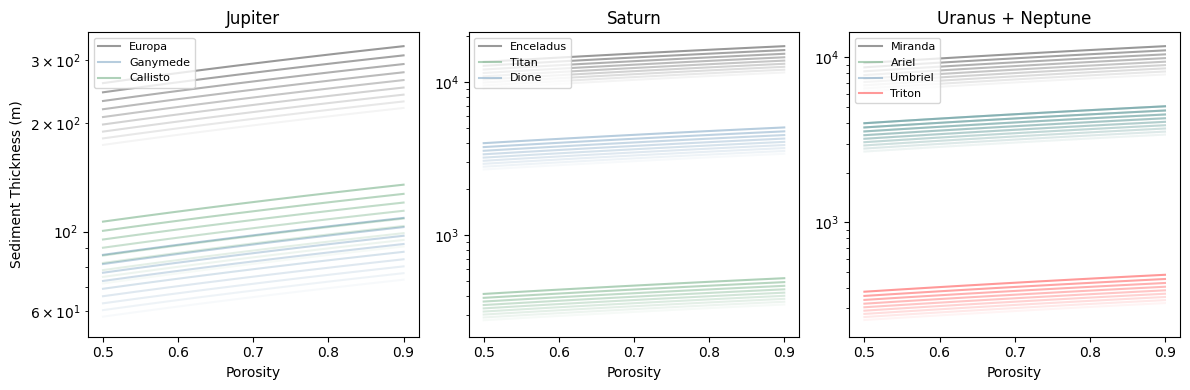

In [ ]:
# Fn Definitions
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def SA_sphere(radius):
    return 4 * 3.1415 * radius**2

# Defining rocky interior radii for moons (from table and converted to m)
moons_data = {
    "Europa": 1374 * 1e3,
    "Ganymede": 2380 * 1e3,
    "Callisto": 2140 * 1e3,
    "Enceladus": 190 * 1e3,
    "Titan": 1087 * 1e3,
    "Dione": 350 * 1e3,
    "Miranda": 230 * 1e3,
    "Ariel": 350 * 1e3,
    "Umbriel": 350 * 1e3,
    "Triton": 1135 * 1e3,
}

# Colors for each moon
colors = {
    "Europa": 'k', "Ganymede": '#4b82ae', "Callisto": '#388e51',
    "Enceladus": 'k', "Titan": '#388e51', "Dione": '#4b82ae',
    "Miranda": 'k', "Ariel": '#388e51', "Umbriel": '#4b82ae', "Triton": 'r'
}

# Defining parameter ranges for the sensitivity analysis
porosity_values = np.linspace(0.5, 0.9, 10)
sediment_density_values = np.linspace(1.1, 1.7, 10) * 1000  # Converting to kg/m³
impactor_diameter = np.logspace(-3, 2, 100)  # Log-scaled impactor diameters (from 1mm to 100m)

# Placeholder mass reservoir for sediment calculation
mass_reservoir = np.ones_like(impactor_diameter) * 1e16  # Example

# Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Looping through each moon and calculating sediment thickness for each combination of porosity and density
for moon, radius_RI in moons_data.items():
    for density in sediment_density_values:
        thickness_values = []
        for porosity in porosity_values:
            thickness = sediment_thickness(mass_reservoir, radius_RI, impactor_diameter, density, porosity, 10, time)
            thickness_values.append(thickness[-1])

        # To assign to correct subplot
        if moon in ["Europa", "Ganymede", "Callisto"]:
            ax1.plot(porosity_values, thickness_values, color=colors[moon], alpha=(1700-density)/1500, label=moon if density == sediment_density_values[0] else "")
        elif moon in ["Enceladus", "Titan", "Dione"]:
            ax2.plot(porosity_values, thickness_values, color=colors[moon], alpha=(1700-density)/1500, label=moon if density == sediment_density_values[0] else "")
        else:
            ax3.plot(porosity_values, thickness_values, color=colors[moon], alpha=(1700-density)/1500, label=moon if density == sediment_density_values[0] else "")

# axis labels and scale
ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log')
ax1.set_xlabel("Porosity"); ax2.set_xlabel("Porosity"); ax3.set_xlabel("Porosity")
ax1.set_ylabel("Sediment Thickness (m)")

# Legend/titles
ax1.set_title("Jupiter")
ax2.set_title("Saturn")
ax3.set_title("Uranus + Neptune")

ax1.legend(loc='upper left', fontsize=8)
ax2.legend(loc='upper left', fontsize=8)
ax3.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
##Sediment thickness calculations
s_Enceladus_A_minr = sediment_thickness(reservoir_Enceladus_A, Enceladus_RI*1e3*.8, d, 1100, .9, 15, time)
s_Europa_A_minr = sediment_thickness(reservoir_Europa_A, Europa_RI*1e3*.8, d, 1100, .9, 15, time)
s_Titan_A_minr = sediment_thickness(reservoir_Titan_A, Titan_RI*1e3*.8, d, 1100, .9, 15, time)
s_Dione_A_minr = sediment_thickness(reservoir_Dione_A, Dione_RI*1e3*.8, d, 1100, .9, 15, time)
s_Ganymede_A_minr = sediment_thickness(reservoir_Ganymede_A, Ganymede_RI*1e3*.8, d, 1100, .9, 15, time)
s_Callisto_A_minr = sediment_thickness(reservoir_Callisto_A, Callisto_RI*1e3*.8, d, 1100, .9, 15, time)
s_Miranda_A_minr = sediment_thickness(reservoir_Miranda_A, Miranda_RI*1e3*.8, d, 1100, .9, 15, time)
s_Ariel_A_minr = sediment_thickness(reservoir_Ariel_A, Ariel_RI*1e3*.8, d, 1100, .9, 15, time)
s_Umbriel_A_minr = sediment_thickness(reservoir_Umbriel_A, Umbriel_RI*1e3*.8, d, 1100, .9, 15, time)
s_Triton_A_minr = sediment_thickness(reservoir_Triton_A, Triton_RI*1e3*.8, d, 1100, .9, 15, time)

s_Enceladus_A_maxr = sediment_thickness(reservoir_Enceladus_A, Enceladus_RI*1e3*1.2, d, 1100, .9, 15, time)
s_Europa_A_maxr = sediment_thickness(reservoir_Europa_A, Europa_RI*1e3*1.2, d, 1100, .9, 15, time)
s_Titan_A_maxr = sediment_thickness(reservoir_Titan_A, Titan_RI*1e3*1.2, d, 1100, .9, 15, time)
s_Dione_A_maxr = sediment_thickness(reservoir_Dione_A, Dione_RI*1e3*1.2, d, 1100, .9, 15, time)
s_Ganymede_A_maxr = sediment_thickness(reservoir_Ganymede_A, Ganymede_RI*1e3*1.2, d, 1100, .9, 15, time)
s_Callisto_A_maxr = sediment_thickness(reservoir_Callisto_A, Callisto_RI*1e3*1.2, d, 1100, .9, 15, time)
s_Miranda_A_maxr = sediment_thickness(reservoir_Miranda_A, Miranda_RI*1e3*1.2, d, 1100, .9, 15, time)
s_Ariel_A_maxr = sediment_thickness(reservoir_Ariel_A, Ariel_RI*1e3*1.2, d, 1100, .9, 15, time)
s_Umbriel_A_maxr = sediment_thickness(reservoir_Umbriel_A, Umbriel_RI*1e3*1.2, d, 1100, .9, 15, time)
s_Triton_A_maxr = sediment_thickness(reservoir_Triton_A, Triton_RI*1e3*1.2, d, 1100, .9, 15, time)

<ipython-input-8-1a503c2fdb2e>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = int(b[0])


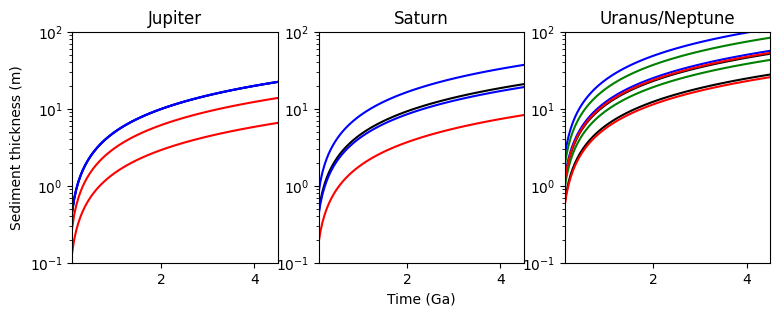

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))

ax1.plot(time, s_Europa_A, 'k');
ax1.plot(time, s_Callisto_A_minr,'r'); ax1.plot(time, s_Callisto_A_maxr, 'r');
ax1.plot(time, s_Ganymede_A_minr,'b'); ax1.plot(time, s_Ganymede_A_minr, 'b');

ax2.plot(time, s_Enceladus_A, 'k');
ax2.plot(time, s_Titan_A,'r');
ax2.plot(time, s_Dione_A_minr,'b'); ax2.plot(time, s_Dione_A_maxr, 'b');

ax3.plot(time, s_Miranda_A_minr, 'k'); ax3.plot(time, s_Miranda_A_maxr, 'k');
ax3.plot(time, s_Ariel_A_minr,'b'); ax3.plot(time, s_Ariel_A_maxr, 'b');
ax3.plot(time, s_Umbriel_A_maxr,'g'); ax3.plot(time, s_Umbriel_A_minr, 'g');
ax3.plot(time, s_Triton_A_minr,'r'); ax3.plot(time, s_Triton_A_maxr, 'r');

#plt.vlines([1.5,5,30],1e-13,1e-5)
ax1.set_xlim(1,4); ax1.set_ylim(1e-1,1e4)
ax2.set_xlim(1,4); ax2.set_ylim(1e-1,1e4)
ax3.set_xlim(1,4); ax3.set_ylim(1e-1,1e4)
ax1.set_ylabel ('Sediment thickness (m)')
ax2.set_xlabel ('Time (Ga)')
#plt.grid(b=True, which='major', color='lightgray', linestyle='-')
ax1.set_yscale('log'); ax2.set_yscale('log'); ax3.set_yscale('log')

#ax1.legend(labels=['Europa Case A','Case B', 'Ganymede Case A', 'Case B', 'Callisto Case A', 'Case B'])
#ax2.legend(labels=['Enceladus Case A','Case B', 'Titan Case A', 'Case B', 'Dione Case A', 'Case B'])
#ax3.legend(labels=['Miranda Case A','Case B', 'Ariel Case A', 'Case B', 'Umbriel Case A', 'Case B', 'Triton Case A', 'Case B'])

ax1.set_title('Jupiter')  # Use set_title() method
ax2.set_title('Saturn')   # Use set_title() method
ax3.set_title('Uranus/Neptune') # Use set_title() method

ax1.set_ylim(1e-1, 1e2); ax2.set_ylim(1e-1, 1e2); ax3.set_ylim(1e-1, 1e2)
ax1.set_xlim(0.1,4.5); ax2.set_xlim(0.1,4.5); ax3.set_xlim(0.1,4.5)


plt.show()
#plt.savefig('C_Jupiter.png', dpi=200)
plt.close()

### Micrometeorite thickness

Optical density is an important parameter for observational astronomy and thus present day distribution of dust in the solar system is well studied and constrained. These observations can be converted into a spatially resolved micrometeorite flux (< 1 mm)([Poppe et al., 2016](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.725.8500&rep=rep1&type=pdf)).

<img src="uJupiter.png" alt="Jupiter" width="300"/><img src="uSaturn.png" alt="Saturn" width="300"/>

We integrate this mass flux over the icy shell of each moon and then assume perfect transport through the ice shell and ocean and evenly distributed deposition on the ocean floor. This is likely an underestimate of the flux integrated through time. We also model the time varying micrometeorite flux by comparing to other solar systems. Recent work on debris disks suggests a decrease of two orders of magnitude over 4 billion years ([Chen et al., 2020](https://www.nature.com/articles/s41550-020-1067-6)). We fit the curve for other debris disks to extrapolate the micrometeroite flux of our solar system over time.

<img src="DD.png" alt="Debris Disk" width="300"/>


In [ ]:
def large_mass_flux(impactor, d, radius_total):
    SA = 4 * np.pi * radius_total**2
    V = 4/3 * np.pi * d**3
    m_flux = c * SA *3000 /V
    return m_flux #m/Ga

def sed_u_thickness(massflux, radius_RI, radius_total, time, rock_density):
    SA_total = 4 * np.pi * radius_total**2 # m2
    iceflux = massflux * SA_total * 3.17e16 *1e-3 #kg/Ga
    SA_RI = 4 * np.pi * radius_RI**2 #m2
    sedflux = iceflux/SA_RI * 1/rock_density #m/Ga
    return sedflux*time #m

## Figure 3

There are three regimes that govern the descent of particle through fluid: a regime where the drag coefficent $C_d$ decreases with velocity (Stokesian), a regime where the drag coefficient plateaus to an experimentally determined constant (Newtonian), and a transitional regime. This can be plotted either in terms of the particle Reynold's number $Re = u_td \rho/\mu$:

Text(0, 0.5, 'Drag coefficient')

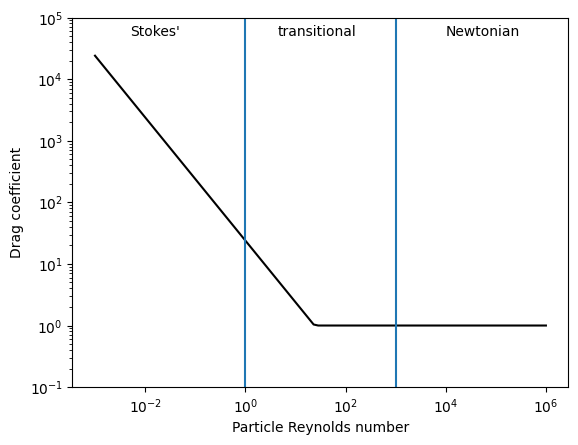

In [ ]:
Re = np.geomspace(1e-3, 1e6, 100)
def drag_coefficient(Re):
    Cd = np.array([])
    for i in np.arange(0,len(Re)):
        if Re[i] < 2.5e1:
            Cd = np.append(Cd, 24/Re[i])
            #print(Cd[i])
        if Re[i] >= 2.5e1:
            Cd = np.append(Cd, 1)
    #print(len(Cd),len(Re))
    return Cd

drag = drag_coefficient(Re)
plt.plot(Re, drag, 'k')
plt.yscale('log'), plt.xscale('log')
plt.ylim(1e-1,1e5)
plt.vlines(1,1e-1,1e5)
plt.vlines(1e3,1e-1,1e5)
plt.text(5e-3,5e4, "Stokes'");plt.text(4.5e0,5e4, "transitional");plt.text(1e4,5e4, "Newtonian")
plt.xlabel('Particle Reynolds number'); plt.ylabel('Drag coefficient')

The terminal settling velocity $\vec{u_t}$ for spherical objects and laminar flow (Re << 1) is given by Stoke's flow (Stokes, 1850) where

$$ \vec{u_t} = \sqrt{\frac{4}{3} \frac{\vec{g}d(\rho_s- \rho_w)}{(C_d)\rho_w}} $$

and $\vec{g}$ is the acceleration of gravity, $d$ is the sediment radius, $\rho_s$ is the sediment density, $\rho_w$ is the density of water, and $C_d$ the particle drag coefficient is $24/Re$ where $Re$ is the particle Reynold's number, and $\mu_w$ is the dynamic viscosity of water.

In [ ]:
#Define constants
earth_g = 9.81 #m/s2
eur_g = 1.32 #m/s2
enc_g = 0.113 #m/s2

def Stokes_velocity (Re, size, gravity, viscosity, density, denisty_w):
    #Re = (size * density)/(viscosity)
    Cd = 24/Re
    v = (4*gravity*size*(density-denisty_w))/(3*Cd*denisty_w)
    return v

v_earth_3 = Stokes_velocity(1e3, d, earth_g, 1e-3, 3e3, 1e3)
v_earth_1 = Stokes_velocity(10, d, earth_g, 1e-3, 3e3, 1e3)
v_earthm1 = Stokes_velocity(.1, d, earth_g, 1e-3, 3e3, 1e3)
v_earthm3 = Stokes_velocity(1e-3, d, earth_g, 1e-3, 3e3, 1e3)
v_earthm5 = Stokes_velocity(1e-5, d, earth_g, 1e-3, 3e3, 1e3)
v_earthm7 = Stokes_velocity(1e-7, d, earth_g, 1e-3, 3e3, 1e3)

Text(0.5, 1.0, "Earth - Stoke's velocity")

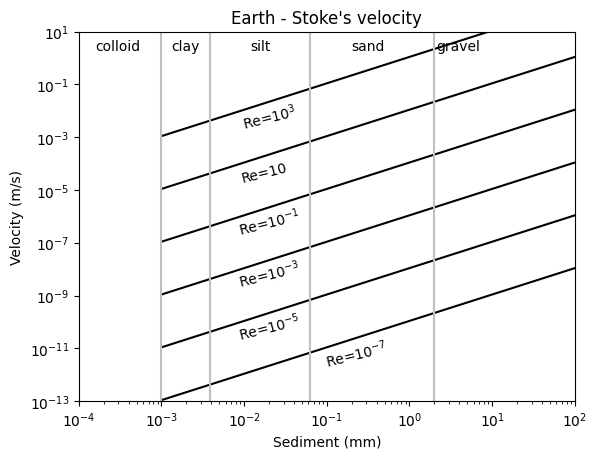

In [ ]:
#Plot Re
plt.plot(d*1e3, v_earth_3, 'k'); plt.plot(d*1e3, v_earth_1, 'k');
plt.plot(d*1e3, v_earthm1, 'k'); plt.plot(d*1e3, v_earthm3, 'k');
plt.plot(d*1e3, v_earthm5, 'k'); plt.plot(d*1e3, v_earthm7, 'k');

#Plot Re labels
plt.text(9.1e-2,2e-12,'Re=10$^{-7}$', rotation=14);plt.text(.8e-2,2e-11,'Re=10$^{-5}$', rotation=14)
plt.text(.8e-2,2e-9,'Re=10$^{-3}$', rotation=14);plt.text(.8e-2,2e-7,'Re=10$^{-1}$', rotation=14)
plt.text(.9e-2,2e-5,'Re=10', rotation=14);plt.text(.9e-2,2e-3,'Re=10$^{3}$', rotation=14)

#Plot grain sizes
plt.vlines(2, 1e-13,1e1, color='silver'); plt.vlines(.063, 1e-13,1e1, color='silver'); plt.vlines(0.0039, 1e-13,1e1, color='silver'); plt.vlines(0.00098, 1e-13,1e1, color='silver')
plt.text(2.1,2,'gravel'); plt.text(.2,2,'sand'); plt.text(.012,2,'silt'); plt.text(.0013,2,'clay');plt.text(.00016,2,'colloid');

#Set axes
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-4,1e2)
plt.ylim(1e-13, 1e1)

#Labels
plt.ylabel("Velocity (m/s)"); plt.xlabel("Sediment (mm)")
plt.title("Earth - Stoke's velocity")

*However*, the particle Re and the settling velocity are not independent. Rubey (1933) formulated the drag coefficient to be $C_d = A_1/Re + A_2$ where A_1 and A_2 are fudge factors. Cheng (1997) modified this further to be $C_d = [(A_1/Re)^{A_3^{-1}}+ (A_2)^{A_3^{-1}}]$ which Fredsøn and Deigaard (1992) fit to experimental data of real to sediment to find $C_d = [(36/Re)+ 1.4]$. In this formulation

$\vec{u_t} = \frac{A_1}{A_2} \frac{\rho_w}{d \mu_w} \large(\sqrt{\frac{1}{4} + \frac{4}{3} \frac{A_2}{A_1^2} D_*^3} - \frac{1}{2} \large)$

where D_* is the particle parameter

$D_*^3 = d^3\frac{(\rho_s - \rho_w)\rho_w \vec{g}}{\mu^2}$ .

In [ ]:
def Rubey_velocity (size, gravity, viscosity, density, density_w):
    A1 = 36; A2 = 1.4 # Cheng
    #A1 = 24; A2 = .44
    D3 = size**3*(density-density_w)*density_w *gravity * viscosity**-2
    v = A1/A2 * (viscosity/(size* density_w)) * \
    ((1/4 + ((4/3)*(A2/(A1**2))*D3))**.5 -.5)
    return v

In [ ]:
v_Rearth = Rubey_velocity(d, earth_g, 1e-3, 3e3, 1e3)
v_Reur = Rubey_velocity(d, eur_g, 1e-3, 3e3, 1e3)
v_Renc = Rubey_velocity(d, enc_g, 1e-3, 3e3, 1e3)

Text(0.5, 1.0, 'Rubey velocity')

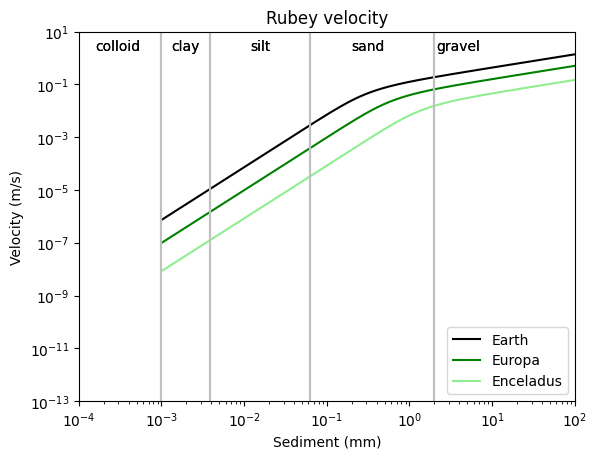

In [ ]:
#Plot u_t
#Plot Re
plt.plot(d*1e3, v_Rearth, 'k');
plt.plot(d*1e3, v_Reur, 'g');
plt.plot(d*1e3, v_Renc, 'lightgreen');

#Plot grain sizes
plt.vlines(2, 1e-13,1e1, color='silver'); plt.vlines(.063, 1e-13,1e1, color='silver'); plt.vlines(0.0039, 1e-13,1e1, color='silver'); plt.vlines(0.00098, 1e-13,1e1, color='silver')
plt.text(2.1,2,'gravel'); plt.text(.2,2,'sand'); plt.text(.012,2,'silt'); plt.text(.0013,2,'clay');plt.text(.00016,2,'colloid');

#Labels
plt.ylabel("Velocity (m/s)"); plt.xlabel("Sediment (mm)")
plt.title("Earth - Stoke's velocity")

#Plot grain sizes
plt.vlines(2, 1e-13,1e1, color='silver'); plt.vlines(.063, 1e-13,1e1, color='silver'); plt.vlines(0.0039, 1e-13,1e1, color='silver'); plt.vlines(0.00098, 1e-13,1e1, color='silver')
plt.text(2.1,2,'gravel'); plt.text(.2,2,'sand'); plt.text(.012,2,'silt'); plt.text(.0013,2,'clay');plt.text(.00016,2,'colloid');

#Set axes
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-4,1e2)
plt.ylim(1e-13, 1e1)

plt.legend(['Earth', 'Europa', 'Enceladus'], loc='lower right')

#Labels
plt.ylabel("Velocity (m/s)"); plt.xlabel("Sediment (mm)")
plt.title("Rubey velocity")

This analysis obscures two important differences among these worlds.

1. The background ocean velocitys $\vec{w} \sim \vec{g}Q $ where Q is the basal heat flux meaning that smaller ocean worlds are likely to allow smaller particles to settle.
    
2. Finally, typical ocean depth on earth is $H \sim O(1)$ km while ocean covered have $H \sim O(10^2)$ km. This means that even for an Earth-like Stoke's velocity, transport through the Enceladus ocean would take ~10x longer and through the Europa ocean ~20x longer.

To address these differences, instead of velocity, I plot settling time through the ocean ($\vec{u}/H$) and plot the possible background ocean circulation times from published studies.

In [ ]:
earth_ocean = 4000; eur_ocean = 70000; enc_ocean = 30000 #m
t_earth = earth_ocean/v_Rearth/3.15e7; t_eur = eur_ocean/v_Reur/3.15e7; t_enc = enc_ocean/v_Renc/3.15e7;
earth_background= 5600; eur_background = 10000; enc_background = 30000 #yrs

Text(0.5, 1.0, 'Settling time')

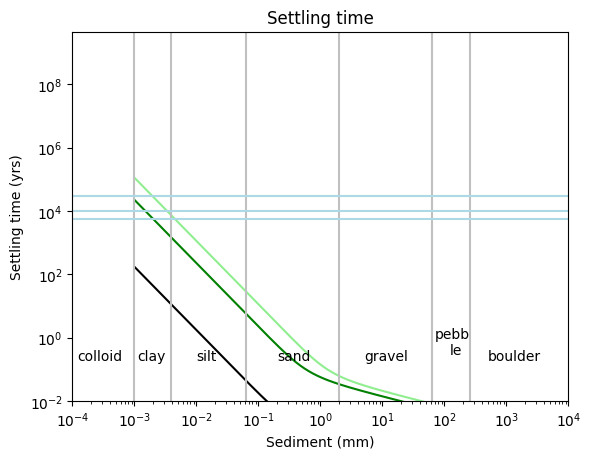

In [ ]:
#Plot Settling times
plt.plot(d*1e3, t_earth, 'k'); plt.plot(d*1e3, t_eur, 'g'); plt.plot(d*1e3, t_enc, 'lightgreen');

#Plot grain sizes
plt.vlines(256, 1e-4,1e17, color='silver'); plt.vlines(64, 1e-4,1e17, color='silver'); plt.vlines(2, 1e-4,1e17, color='silver'); plt.vlines(.063, 1e-4,1e17, color='silver'); plt.vlines(0.0039, 1e-4,1e17, color='silver'); plt.vlines(0.00098, 1e-4,1e17, color='silver')
plt.text(5e2,.2,'boulder'); plt.text(70.1,1,'pebb'); plt.text(120,.3,'le'); plt.text(5.1,.2,'gravel'); plt.text(.2,.2,'sand'); plt.text(.01,.2,'silt'); plt.text(.0011,.2,'clay');plt.text(.00012,.2,'colloid');

#Plot ocean circulation times
plt.hlines(earth_background, 1e-4,1e4, color = 'lightblue')
plt.hlines(eur_background, 1e-4,1e4, color = 'lightblue')
plt.hlines(enc_background, 1e-4,1e4, color = 'lightblue')

#Set axes
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-4,1e4)
plt.ylim(1e-2, 4.7e9)

#Labels
plt.ylabel("Settling time (yrs)"); plt.xlabel("Sediment (mm)")
plt.title("Settling time")

A more empirical form is given by Rubey (1933) which captures the dynamic changes in drag for different particle sizes.  

(*Eq'n 5*) $ \vec{u}  = \frac{-18 \mu \pm \sqrt{18^2 \mu^2 + 6 \vec{g} d^3 \rho_w (\rho_s- \rho_w )}}{3 d \rho_w}$

Maggi (2013) modify this general form with 3 shape factors for aggregate particles to fit observational data

(*Eq'n 13a*) $ H = \frac{\sqrt {\pi} }{3} (\frac{\pi d^2}{4})^{\alpha/2\delta^2\lambda^{2\gamma}+\beta/2}$   

(*Eq'n 13b*) $ K = \frac{\pi}{6} d$

(*Eq'n 13c*) $ Z^2 = d^2 \frac{\pi^2}{36} \lambda^{\delta \lambda \gamma -3}$

where an aggregate of size $d$ made of a characteristic particle size $d_p$ and the non-dimensional size $\lambda = d/d_p$. The fractal dimension $\delta$ is ~3 for solid minerals. $\gamma$ is the multifractality exponent. The fudge/geometric factors are $\alpha$ and $\beta$.

where yielding

(*Eq'n 11*) $ \vec{u} = \frac{-18 \mu H \pm \sqrt{18^2 \mu^2 H^2 + 6 \vec{g} d^3 \rho_w (\rho_s - \rho_w) Z^2}}{3 d \rho_w K}.$

He then fits the data below to calculate the mean

||$\delta$|$\gamma$|$d_p$|$\rho_s$|
|-|-|-|-|-|
|**Mineral**|2.4|0.00|0.2|2800|
|**Aggregates**|2.4|-0.03|2|2800|
|**Biomineral**|2.5|-0.04|4|1700|
|**Biological**|2.9|-0.06|8|1100|


In [ ]:
def Maggi_velocity(delta, dp, gamma, size, gravity, viscosity, density, density_w):
    alpha = 9/8; beta = 7/8; lamb = size/(dp*10e-6)
    H = (np.pi)**.5 * 1/3 * (np.pi*size**2*1/4)**(alpha/(2*delta**2*lamb**(2*gamma))+beta/2)
    K = (np.pi/6)*size
    #H = K
    Z2 = size**2 * np.pi**2 *(1/36) * lamb**(delta*lamb*gamma-3)
    Z2 = size**2 * np.pi**2 *(1/36)
    #print(H,K,Z2)
    Y = 18**2 * viscosity**2 * H**2 +6*gravity*size**3*density_w*(density-density_w)*Z2
    v = (-18*viscosity*H+np.sqrt(Y))/(3*size*density_w*K)
    #v=H
    return (v)

In [ ]:
v_earth_p  = Maggi_velocity(2.4,.2,0   , d, earth_g, 1e-3, 2.8e3, 1e3)
v_earth_a  = Maggi_velocity(2.4, 2,-.03, d, earth_g, 1e-3, 2.8e3, 1e3)
v_earth_bm = Maggi_velocity(2.5, 4,-.04, d, earth_g, 1e-3, 1.7e3, 1e3)
v_earth_b  = Maggi_velocity(2.9, 8,-.06, d, earth_g, 1e-3, 1.1e3, 1e3)

v_eur_p = Maggi_velocity(2.4, .2,0, d, eur_g, 1e-3, 2.8e3, 1e3)
v_eur_a = Maggi_velocity(2.4, 2,-.03, d, eur_g, 1e-3, 2.8e3, 1e3)
v_eur_bm = Maggi_velocity(2.5, 4,-.04, d, eur_g, 1e-3, 1.7e3, 1e3)
v_eur_b = Maggi_velocity(2.9, 8,-.06,d, eur_g, 1e-3, 1.1e3, 1e3)

v_enc_p = Maggi_velocity(2.4, .2,0, d, enc_g, 1e-3, 2.8e3, 1e3)
v_enc_a = Maggi_velocity(2.4, 2,-.03, d, enc_g, 1e-3, 2.8e3, 1e3)
v_enc_bm = Maggi_velocity(2.5, 4,-.04, d, enc_g, 1e-3, 1.7e3, 1e3)
v_enc_b = Maggi_velocity(2.9, 8,-.06,d, enc_g, 1e-3, 1.1e3, 1e3)

Text(0.5, 1.0, 'Earth -- Maggi velocity')

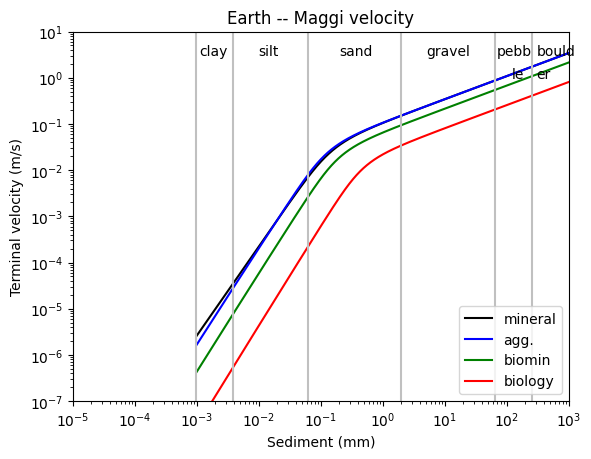

In [ ]:
#Plot Settling times
plt.plot(d*1e3, v_earth_p, 'k', label='mineral'); plt.plot(d*1e3, v_earth_a, 'b', label = 'agg.'); plt.plot(d*1e3, v_earth_bm, 'g', label = 'biomin'); plt.plot(d*1e3,v_earth_b,'r', label = 'biology');

#Plot grain sizes
plt.vlines(256, 1e-7,1e1, color='silver'); plt.vlines(64, 1e-7,1e1, color='silver'); plt.vlines(2, 1e-7,1e1, color='silver'); plt.vlines(.063, 1e-7,1e1, color='silver'); plt.vlines(0.0039, 1e-7,1e1, color='silver'); plt.vlines(0.00098, 1e-7,1e1, color='silver')
plt.text(3e2,3,'bould');plt.text(3e2,1,'er'); plt.text(70.1,3,'pebb'); plt.text(120,1,'le'); plt.text(5.1,3,'gravel'); plt.text(.2,3,'sand'); plt.text(.01,3,'silt'); plt.text(.0011,3,'clay');

#Set axes
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-5,1e3)
plt.ylim(1e-7,1e1)
plt.legend(loc='lower right')

#Labels
plt.ylabel("Terminal velocity (m/s)"); plt.xlabel("Sediment (mm)")
plt.title("Earth -- Maggi velocity")

Text(0.5, 1.0, 'Europa -- Maggi velocity')

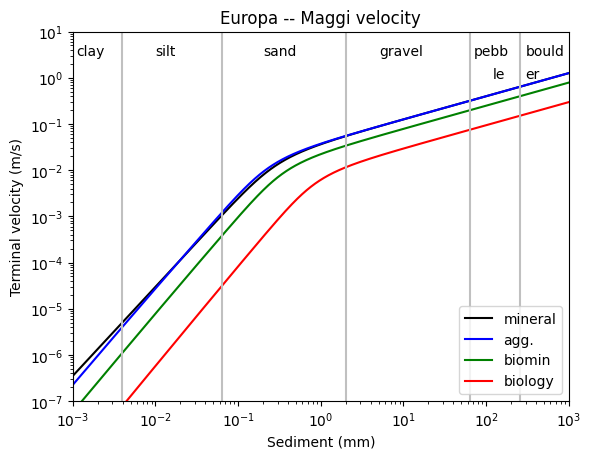

In [ ]:
#Plot Settling times
plt.plot(d*1e3, 1*v_eur_p, 'k', label = 'mineral'); plt.plot(d*1e3, 1*v_eur_a, 'b', label = 'agg.'); plt.plot(d*1e3, v_eur_bm, 'g', label = 'biomin'); plt.plot(d*1e3,v_eur_b,'r', label = 'biology');

#Plot grain sizes
plt.vlines(256, 1e-7,1e1, color='silver'); plt.vlines(64, 1e-7,1e1, color='silver'); plt.vlines(2, 1e-7,1e1, color='silver'); plt.vlines(.063, 1e-7,1e1, color='silver'); plt.vlines(0.0039, 1e-7,1e1, color='silver'); plt.vlines(0.00098, 1e-7,1e1, color='silver')
plt.text(3e2,3,'bould');plt.text(3e2,1,'er'); plt.text(70.1,3,'pebb'); plt.text(120,1,'le'); plt.text(5.1,3,'gravel'); plt.text(.2,3,'sand'); plt.text(.01,3,'silt'); plt.text(.0011,3,'clay');

#Set axes
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-3,1e3)
plt.ylim(1e-7,1e1)
plt.legend(loc='lower right')

#Labels
plt.ylabel("Terminal velocity (m/s)"); plt.xlabel("Sediment (mm)")
plt.title("Europa -- Maggi velocity")

In [ ]:
t_earth_p = earth_ocean/v_earth_p/3.15e7; t_earth_a = earth_ocean/v_earth_a/3.15e7; t_earth_bm = earth_ocean/v_earth_bm/3.15e7; t_earth_b = earth_ocean/v_earth_b/3.15e7;
t_eur_p = eur_ocean/v_eur_p/3.15e7; t_eur_a = eur_ocean/v_eur_a/3.15e7; t_eur_bm = eur_ocean/v_eur_bm/3.15e7; t_eur_b = eur_ocean/v_eur_b/3.15e7;
t_enc_p = enc_ocean/v_enc_p/3.15e7; t_enc_a = enc_ocean/v_enc_a/3.15e7; t_enc_bm = enc_ocean/v_enc_bm/3.15e7; t_enc_b = enc_ocean/v_enc_b/3.15e7;

Text(0.5, 1.0, 'Settling time')

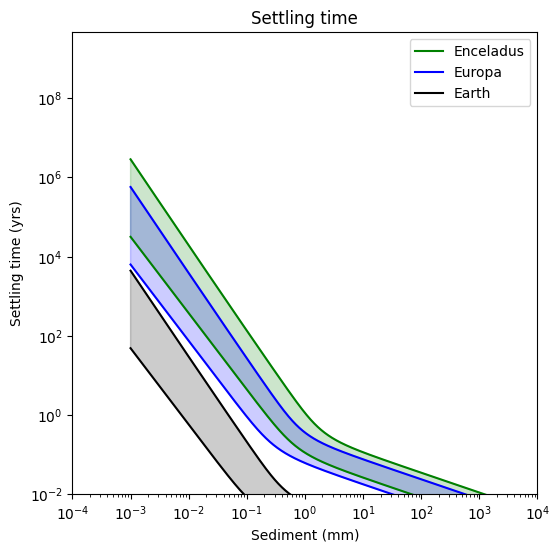

In [ ]:
#Plot Settling times
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

ax1.fill_between(d*1e3, t_enc_b, t_enc_p, color='g', alpha=.2)
ax1.plot(d*1e3,t_enc_b,'g', label = 'Enceladus');
ax1.plot(d*1e3,t_enc_p,'g')

ax1.fill_between(d*1e3, t_eur_b, t_eur_p, color='b', alpha=.2)
ax1.plot(d*1e3,t_eur_b,'b', label = 'Europa');
ax1.plot(d*1e3,t_eur_p,'b')

ax1.fill_between(d*1e3, t_earth_b, t_earth_p, color='k', alpha=.2)
ax1.plot(d*1e3,t_earth_b,'k', label = 'Earth');
ax1.plot(d*1e3,t_earth_p,'k')


#Plot grain sizes
#plt.vlines(256, 1e-7,1e1, color='silver'); plt.vlines(64, 1e-7,1e1, color='silver'); plt.vlines(2, 1e-7,1e1, color='silver'); plt.vlines(.063, 1e-7,1e1, color='silver'); plt.vlines(0.0039, 1e-7,1e1, color='silver'); plt.vlines(0.00098, 1e-7,1e1, color='silver')
#plt.text(3e2,3,'bould');plt.text(3e2,1,'er'); plt.text(70.1,3,'pebb'); plt.text(120,1,'le'); plt.text(5.1,3,'gravel'); plt.text(.2,3,'sand'); plt.text(.01,3,'silt'); plt.text(.0011,3,'clay');

#Set axes
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-4,1e4)
plt.ylim(1e-2, 4.7e9)
plt.legend(loc='upper right')

#Labels
plt.ylabel("Settling time (yrs)"); plt.xlabel("Sediment (mm)")
plt.title("Settling time")

We can also calculate the reaction of sediment during settling from Daval et al. (2022). Time for serpentinization ($\tau$) is given by dividing the grain radius $r_{grain}$ by the dissolution rate

$$ \tau = \int^{r_{grain}}_{0} \frac{1}{\bar{V} R_i} dr $$

where $V_i$ is the molar volume and the dissolution rate far from equilibrium $R_i$ is given by

$$ R_i = k_0 exp(-E_a/RT)(H^+)^n$$

where $k_0$ is the reaction coefficient, $E_a$ is the activation energy, $R$ is the gas constant, $T$ is the temperature, and $H^+$ is the activity of the protons ($10^{pH}$).

|||(units)|olivine|pyroxene|
|-|-|-|-|-|
|reaction coefficient|$k_0$|mol/m$^2$/s|11746|170|
|activation energy|$E_a$|kJ/mol|66.4|80|
|molar volume|V|cm$^3$|45|31|
|reaction order|n||0.256|0|
|gas constant|R|J/mol/K|8.314|8.314|
||pH||9|9|



In [ ]:
R = 8.314; pH = 9;

ol_k0 = 11746; ol_Ea = 66.4*1e3; ol_V = 45*1e-6; ol_Hn = (10**(-1*pH))**.256
ol_Ri_0 = ol_k0 * np.exp((-1*ol_Ea)/(R*273))*ol_Hn; ol_time_0 = d/(ol_V*ol_Ri_0)/3.15e7; ol_time_0p1 = (d*1e-1)/(ol_V*ol_Ri_0)/3.15e7; ol_time_0p01 = (d*1e-2)/(ol_V*ol_Ri_0)/3.15e7
ol_Ri_25 = ol_k0 * np.exp((-1*ol_Ea)/(R*298))*ol_Hn; ol_time_25 = d/(ol_V*ol_Ri_25)/3.15e7

Text(0.5, 1.0, 'Settling time without background currents')

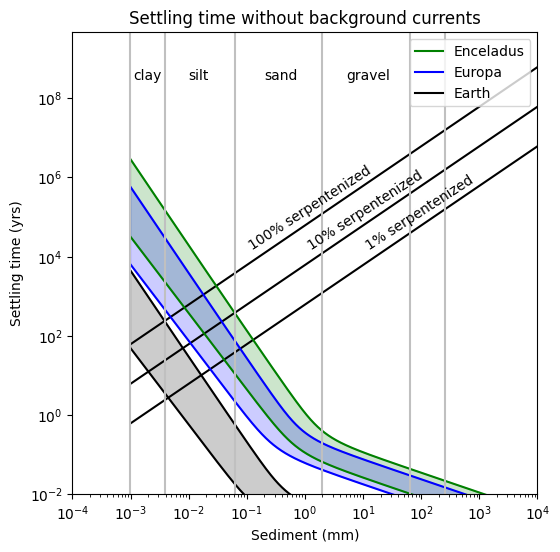

In [ ]:
#Plot Settling times
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

#ax1.fill_between(d*1e3, ol_time_0, 1e20, color='#b3e6b3')
ax1.plot(d*1e3, ol_time_0, 'k'); plt.text(.1, 1.5e4, '100% serpentenized', rotation=33)
ax1.plot(d*1e3, ol_time_0p1, 'k'); plt.text(1, 1.5e4, '10% serpentenized', rotation=33)
ax1.plot(d*1e3, ol_time_0p01, 'k'); plt.text(10, 1.5e4, '1% serpentenized', rotation=33)

ax1.fill_between(d*1e3, t_enc_b, t_enc_p, color='g', alpha=.2)
ax1.plot(d*1e3,t_enc_b,'g', label = 'Enceladus');
ax1.plot(d*1e3,t_enc_p,'g')

ax1.fill_between(d*1e3, t_eur_b, t_eur_p, color='b', alpha=.2)
ax1.plot(d*1e3,t_eur_b,'b', label = 'Europa');
ax1.plot(d*1e3,t_eur_p,'b')

ax1.fill_between(d*1e3, t_earth_b, t_earth_p, color='k', alpha=.2)
ax1.plot(d*1e3,t_earth_b,'k', label = 'Earth');
ax1.plot(d*1e3,t_earth_p,'k')


#Plot grain sizes
plt.vlines(256, 1e-7,5e9, color='silver'); plt.vlines(64, 1e-7,5e9, color='silver'); plt.vlines(2, 1e-7,5e9, color='silver'); plt.vlines(.063, 1e-7,5e9, color='silver'); plt.vlines(0.0039, 1e-7,5e9, color='silver'); plt.vlines(0.00098, 1e-7,5e9, color='silver')
plt.text(5.1,3e8,'gravel'); plt.text(.2,3e8,'sand'); plt.text(.01,3e8,'silt'); plt.text(.0011,3e8,'clay');

#Set axes
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-4,1e4)
plt.ylim(1e-2, 4.7e9)
plt.legend(loc='upper right')

#Labels
plt.ylabel("Settling time (yrs)"); plt.xlabel("Sediment (mm)")
plt.title("Settling time without background currents")

In [ ]:
def settling_time_current (current_v, settling_v, ocean):
    settling_time = np.array([])
    for c in settling_v:

        if current_v >= c:
            a = 1e18
            settling_time = np.append(settling_time, a)
        else:
            a = ocean/(c-current_v)/3.15e7
            settling_time = np.append(settling_time, a)
    return settling_time

In [ ]:
t_earth_p_c = settling_time_current(1e-2, v_earth_p, earth_ocean); t_earth_b_c = settling_time_current(1e-2, v_earth_b, earth_ocean);
t_eur_p_c = settling_time_current(1e-2, v_eur_p, eur_ocean); t_eur_b_c = settling_time_current(1e-2, v_eur_b, eur_ocean);
t_enc_p_c = settling_time_current(1e-2, v_enc_p, enc_ocean); t_enc_b_c = settling_time_current(1e-2, v_enc_b, enc_ocean);

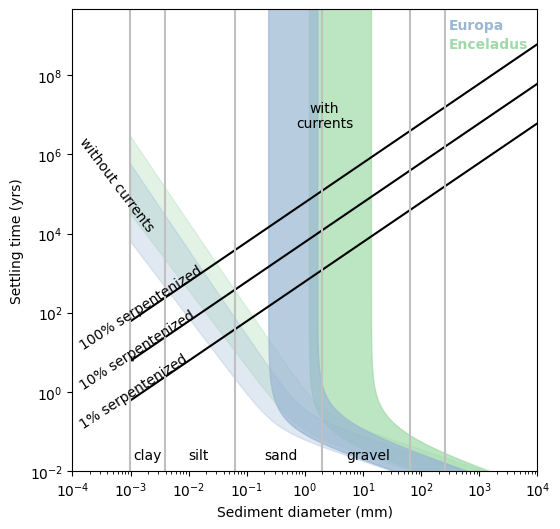

In [ ]:
#Plot Settling times
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

#ax1.fill_between(d*1e3, ol_time_0, 1e20, color='#b3e6b3')
ax1.plot(d*1e3, ol_time_0, 'k'); plt.text(1.2e-4, 12, '100% serpentenized', rotation=33)
ax1.plot(d*1e3, ol_time_0p1, 'k'); plt.text(1.2e-4, 1.2e0, '10% serpentenized', rotation=33)
ax1.plot(d*1e3, ol_time_0p01, 'k'); plt.text(1.2e-4, 1.2e-1, '1% serpentenized', rotation=33)

ax1.fill_between(d*1e3, t_enc_b_c, t_enc_p_c, color='#A0DAA9', alpha=.7)
ax1.fill_between(d*1e3, t_enc_b, t_enc_p, color='#A0DAA9', alpha=.3)
#ax1.plot(d*1e3,t_enc_b_c,'g', label = 'Enceladus');
#ax1.plot(d*1e3,t_enc_p_c,'g')

ax1.fill_between(d*1e3, t_eur_b_c, t_eur_p_c, color='#9BB7D4', alpha=.7)
ax1.fill_between(d*1e3, t_eur_b, t_eur_p, color='#9BB7D4', alpha=.3)
#ax1.plot(d*1e3,t_eur_b_c,'b', label = 'Europa');
#ax1.plot(d*1e3,t_eur_p_c,'b')

#ax1.fill_between(d*1e3, t_earth_b_c, t_earth_p_c, color='k', alpha=.2)
#ax1.fill_between(d*1e3, t_earth_b, t_earth_p, color='k', alpha=.1)
#ax1.plot(d*1e3,t_earth_b_c,'k', label = 'Earth');
#ax1.plot(d*1e3,t_earth_p_c,'k')

plt.text(1.2e-4, 1.2e4, 'without currents', rotation=-53)
plt.text(1.2, 1.2e7, 'with'); plt.text(.7, .5e7, 'currents')

#Plot grain sizes
plt.vlines(256, 1e-7,5e9, color='silver'); plt.vlines(64, 1e-7,5e9, color='silver'); plt.vlines(2, 1e-7,5e9, color='silver'); plt.vlines(.063, 1e-7,5e9, color='silver'); plt.vlines(0.0039, 1e-7,5e9, color='silver'); plt.vlines(0.00098, 1e-7,5e9, color='silver')
plt.text(5.1,2e-2,'gravel'); plt.text(.2,2e-2,'sand'); plt.text(.01,2e-2,'silt'); plt.text(.0011,2e-2,'clay');

#Set axes
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-4,1e4)
plt.ylim(1e-2, 4.7e9)
#plt.legend(loc='upper right')

#Labels
plt.ylabel("Settling time (yrs)"); plt.xlabel("Sediment diameter (mm)")
plt.text(3e2,1.5e9,'Europa', c='#9BB7D4', weight='bold'); plt.text(3e2,.5e9,'Enceladus', c='#A0DAA9', weight='bold');
#plt.title("Settling time with background currents")
plt.savefig('stokes_current.png', dpi=600)

## Figure 4

In [ ]:
density = 1019.99; K_sed = 6.25e-11; viscosity = 1.6e-3; s_yr = 365.25*24*3600; expansity=2e-4; T_o = 1

def seepage_rate (maxdepth, T_aq, permeability, gravity, circulation_depth):
    z = np.arange (0.01,maxdepth)
    K_sed = permeability * density * gravity / viscosity
    driving_P = density*expansity*(T_aq-T_o)* gravity* circulation_depth
    print(driving_P)
    q = K_sed * driving_P/density/gravity/z
    return q*s_yr

In [ ]:
Thickness = np.arange (0.01,1000)

Enceladus_14 = seepage_rate (1000, 100, 1e-14, .01, 2e3); Enceladusmet_14 = seepage_rate (20, 100, 1e-14, .01, 2e3);
Europa_14 = seepage_rate (1000, 100, 1e-14, .1, 2e3); Europamet_14 = seepage_rate (25, 100, 1e-14, .1, 2e3);
Earth_14 = seepage_rate (1000, 100, 1e-14, 9.81, 2e3); Earthmet_14 = seepage_rate (100, 100, 1e-14, 9.81, 2e3);
Ariel_14 = seepage_rate (1000, 100, 1e-14, .25, 2e3); Arielmet_14 = seepage_rate (90, 100, 1e-14, .25, 2e3);
Gan_14 = seepage_rate (1000, 100, 1e-14, 1.4, 2e3); Ganmet_14 = seepage_rate (15, 100, 1e-14, 1.4, 2e3);


Enceladus_16 = seepage_rate (1000, 100, 1e-16, .01, 2e3); Enceladusmet_16 = seepage_rate (20, 100, 1e-16, .01, 2e3);
Europa_16 = seepage_rate (1000, 100, 1e-16, .1, 2e3); Europamet_16 = seepage_rate (25, 100, 1e-16, .1, 2e3);
Earth_16 = seepage_rate (1000, 100, 1e-16, 9.81, 2e3); Earthmet_16 = seepage_rate (100, 100, 1e-16, 9.81, 2e3);
Ariel_16 = seepage_rate (1000, 100, 1e-16, .25, 2e3); Arielmet_16 = seepage_rate (90, 100, 1e-16, .25, 2e3);
Gan_16 = seepage_rate (1000, 100, 1e-16, 1.4, 2e3); Ganmet_16 = seepage_rate (15, 100, 1e-16, 1.4, 2e3);

Enceladus_15 = seepage_rate (1000, 100, 1e-15, .01, 2e3); Enceladusmet_15 = seepage_rate (20, 100, 1e-15, .01, 2e3);
Europa_15 = seepage_rate (1000, 100, 1e-15, .1, 2e3); Europamet_15 = seepage_rate (25, 100, 1e-15, .1, 2e3);
Earth_15 = seepage_rate (1000, 100, 1e-15, 9.81, 2e3); Earthmet_15 = seepage_rate (100, 100, 1e-15, 9.81, 2e3);
Ariel_15 = seepage_rate (1000, 100, 1e-15, .25, 2e3); Arielmet_15 = seepage_rate (90, 100, 1e-15, .25, 2e3);
Gan_15 = seepage_rate (1000, 100, 1e-15, 1.4, 2e3); Ganmet_15 = seepage_rate (15, 100, 1e-15, 1.4, 2e3);

403.91604
403.91604
4039.1604
4039.1604
396241.63524000003
396241.63524000003
10097.901
10097.901
56548.245599999995
56548.245599999995
403.91604
403.91604
4039.1604
4039.1604
396241.63524000003
396241.63524000003
10097.901
10097.901
56548.245599999995
56548.245599999995
403.91604
403.91604
4039.1604
4039.1604
396241.63524000003
396241.63524000003
10097.901
10097.901
56548.245599999995
56548.245599999995


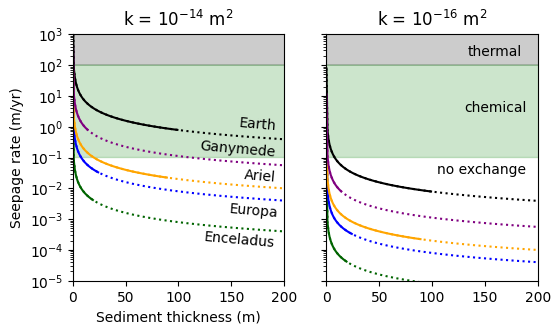

In [ ]:
fig, (ax1, ax3) = plt.subplots(1,2, figsize=(6, 3.2), sharey=True)

ax3.plot(Thickness, Enceladus_16, c='darkgreen', linestyle='dotted'); ax1.plot(Thickness, Enceladus_14, c='darkgreen', linestyle='dotted')
ax3.plot(Thickness, Europa_16, c = 'blue', linestyle='dotted'); ax1.plot(Thickness, Europa_14, c = 'blue', linestyle='dotted')
ax3.plot(Thickness, Earth_16, 'k', linestyle='dotted'); ax1.plot(Thickness, Earth_14, 'k', linestyle='dotted')
ax3.plot(Thickness, Ariel_16, 'orange', linestyle='dotted'); ax1.plot(Thickness, Ariel_14, 'orange', linestyle='dotted')
ax3.plot(Thickness, Gan_16, 'purple', linestyle='dotted'); ax1.plot(Thickness, Gan_14, 'purple', linestyle='dotted')

ax1.plot(Thickness[0:len(Enceladusmet_14)], Enceladusmet_14,  c='darkgreen'); ax3.plot(Thickness[0:len(Enceladusmet_16)], Enceladusmet_16, c='darkgreen')
ax1.plot(Thickness[0:len(Europamet_14)], Europamet_14,  c='blue'); ax3.plot(Thickness[0:len(Europamet_16)], Europamet_16, c='blue')
ax1.plot(Thickness[0:len(Earthmet_14)], Earthmet_14,  c='k'); ax3.plot(Thickness[0:len(Earthmet_16)], Earthmet_16, c='k')
ax1.plot(Thickness[0:len(Arielmet_14)], Arielmet_14,  c='orange'); ax3.plot(Thickness[0:len(Arielmet_16)], Arielmet_16, c='orange')
ax1.plot(Thickness[0:len(Ganmet_14)], Ganmet_14,  c='purple'); ax3.plot(Thickness[0:len(Ganmet_16)], Ganmet_16, c='purple')

ax1.fill_between(Thickness, 1e2, 1e4, color='k', alpha=.2); ax3.fill_between(Thickness, 1e2, 1e4, color='k', alpha=.2);
ax1.fill_between(Thickness, 1e-1, 1e2, color='g', alpha=.2); ax3.fill_between(Thickness, 1e-1, 1e2, color='g', alpha=.2);

ax3.text(134, 200, 'thermal'); ax3.text(130, 3, 'chemical'); ax3.text(105, 3e-2, 'no exchange')

ax1.text(124, 1.2e-4, 'Enceladus', rotation = -5); ax1.text(147, 1.2e-3, 'Europa', rotation = -5); ax1.text(162, 1.6e-2, 'Ariel', rotation = -5); ax1.text(120, .11, 'Ganymede', rotation = -5); ax1.text(157, .8, 'Earth', rotation = -5);

ax1.set_ylim(1e-5,1e3); ax1.set_xlim(0,200); ax3.set_xlim(0,200);
ax1.set_ylabel('Seepage rate (m/yr)'); ax1.set_xlabel('Sediment thickness (m)');  ax2.set_xlabel('Sediment thickness (m)');
ax1.set_title('k = $10^{-14}$ m$^2$'); ax3.set_title('k = $10^{-16}$ m$^2$');
ax1.set_yscale('log');

plt.savefig('SeepageNew.png', dpi=200)